In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import copy

from pygsp import graphs, filters, reduction, plotting
from scipy import sparse, stats

%matplotlib inline

## Task3 - The matches

### 3.1 Analysis of the number of views table

Number of views for a team should peak on the days that team played a match. Let's check it for a single team - the Croatian national football team.

In [2]:
# import table with the number of views 
nodes = pd.read_csv('./Data/All_Nodes_During_WC_Normalised.csv', sep='\t', encoding= 'utf-16')
# get teams
teams = nodes[nodes['Category'] == 'National Team']
# get Croatian national team 783
cnt = teams.loc[783]

cnt = cnt.reset_index()
cnt = cnt.drop([0, 1, 43])
cnt = cnt.reset_index(drop = True)

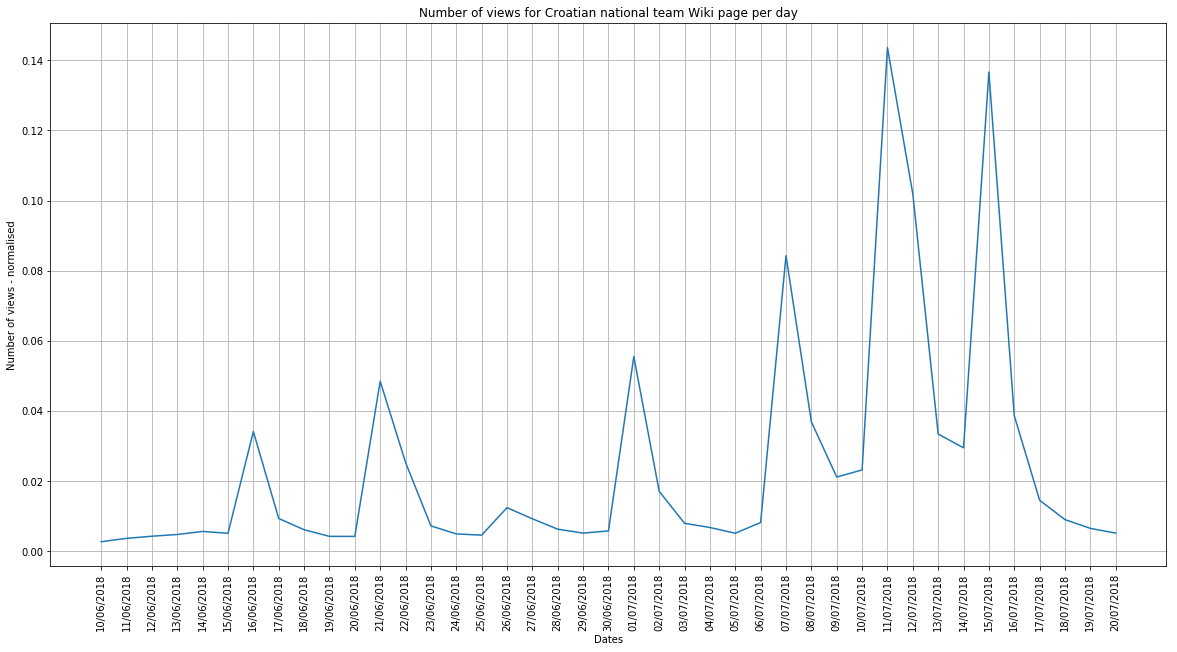

In [3]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.plot(cnt['index'], cnt[783])
plt.title("Number of views for Croatian national team Wiki page per day")
plt.xlabel('Dates')
plt.ylabel('Number of views - normalised')
plt.grid()
plt.show()

__We can clearly see 7 peaks on the above graph.__ Directly from the graph, we read these peaks as the dates 16/06, 21/06, 26/06, 01/07, 07/07, 11/07, and 15/07. These are __exactly the days that Croatia has played__ matches on the World Cup. Expectedly, the largest peaks - 11/07 and 15/07, correspond to the semi-finals against England and finals against France. 

Now we know that the number of views for a team Wiki page should correlate very well with the fact that team played on that day. 

### 3.2 Finding matches with graphs

We are interested in finding out __which countries played matches on which day.__ To find out this, we will create a graph for each day of the competition. All graphs will have the same nodes - the 32 national teams. For each day-graph, the nodes (teams) will be connected if both teams had a peak in Wiki page views on that day. So by looking at the graph, the connected nodes should be teams which played on that day.  

In [88]:
# get teams
teams = teams.reset_index(drop = True)
# get countries (used only for graph labels)
countries = nodes[nodes['Category'] == 'Country']
countries = countries.reset_index(drop=True)

In [90]:
# function for establishing is there a peak in views on a particular day
# we claim that there is a peak if the number of views on that day is
# larger by PEAK_CONSTANT from day before and after
PEAK_CONSTANT = 0.013
def is_a_peak(teams, team, date):
    return teams[date][team][date] > PEAK_CONSTANT + teams.iloc[team][date-1] and \
        teams.iloc[team][date] > PEAK_CONSTANT + teams.iloc[team][date+1]

In [106]:
def draw_graph_for_date(date_string):
    teams_list = list(teams)
    date = teams_list.index(date_string)
    
    # create graph nodes
    G = nx.Graph()
    n_nodes = len(teams)
    for i in range(n_nodes):
        G.add_node(countries.iloc[i][0])
    
    # create graph edges
    node_colors = ["red"] * n_nodes
    adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
    for i in range(n_nodes):
        if is_a_peak(teams, i, date):
            for j in range(n_nodes):
                if i is not j and is_a_peak(teams, j, date):
                    G.add_edge(countries.iloc[i][0], countries.iloc[j][0])
                    node_colors[i] = 'green'
                    node_colors[j] = 'green'

    # draw graph 16 14
    plt.figure(figsize=(11,11))
    nx.draw_networkx(G, pos=nx.circular_layout(G), node_color=node_colors, node_size=1200,
                     font_size=14, font_weight='bold')
    plt.title("Countries playing matches on " + date_string)
    plt.show()

Let's have an example to see if this works. Looking at the [official FIFA page](https://www.fifa.com/worldcup/matches/), __6 countries played on June 19__: Colombia, Japan, Poland, Senegal, Russia and Egypt.

Now let's check our graph for the day June 19. 

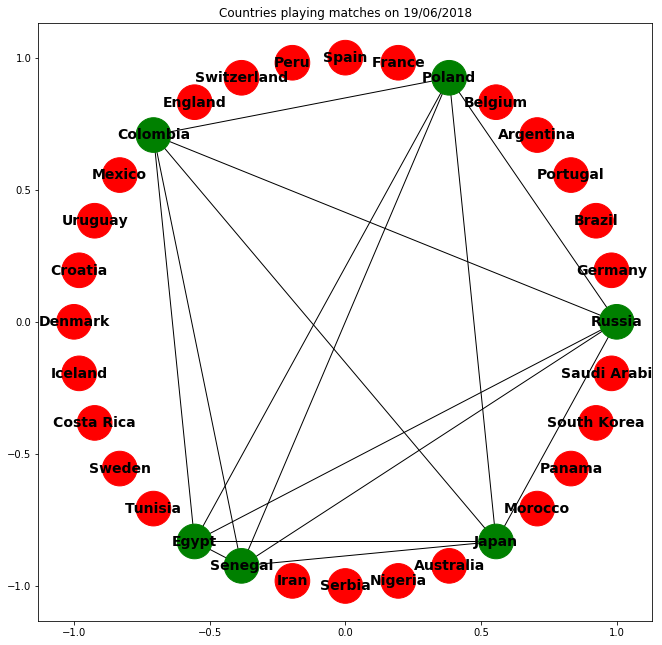

In [107]:
draw_graph_for_date("19/06/2018")

_Voilà!_ Exactly those 6 countries are connected (green) on our graph. It seems to work very well! Let's have another example - let's take the day of the finals, 15/07. As you probably know, __Croatia and France played in the finals.__

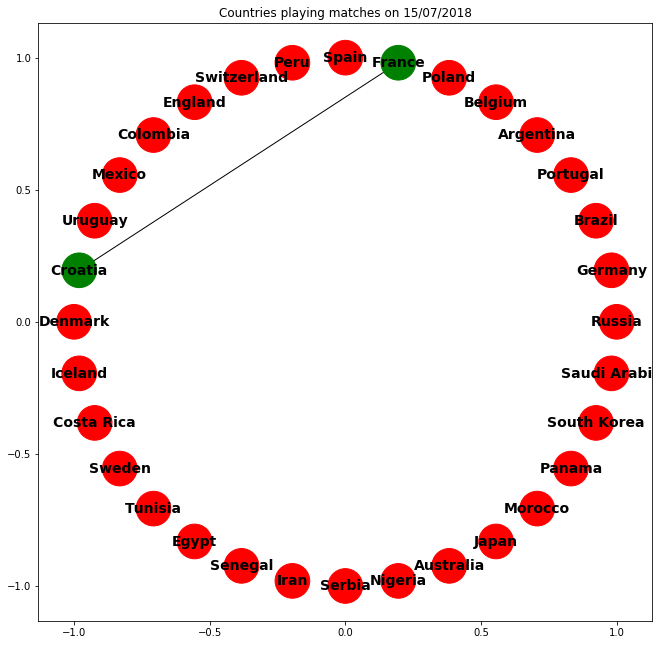

In [108]:
draw_graph_for_date("15/07/2018")

_Oh là là!_ Very nice. __It also works perfectly for the finals.__